In [353]:
!pip install sagemaker-experiments
!pip install python-dotenv
!pip install keras
!pip install tensorflow

# IMPORT LIBRARY

In [1]:
import re
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from decimal import *
import pprint

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,7)})
from scipy.sparse import lil_matrix
import boto3
import sagemaker
from sagemaker import get_execution_role
import io
import sagemaker.amazon.common as smac

from sagemaker.tuner import HyperparameterTuner
from sagemaker.tuner import IntegerParameter, ContinuousParameter

from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer
import psycopg2
import os
from dotenv import load_dotenv
from tensorflow import keras

In [2]:
print("psycopg2 version:", psycopg2.__version__)

psycopg2 version: 2.9.7 (dt dec pq3 ext lo64)


# AWS ENVIRONMENT CONFIGURATION AND GETTING DATA

In [ ]:
# from psycopg2 import sql
# import psycopg2
# import pandas as pd
# import boto3
# import os
# from sqlalchemy import create_engine
# from dotenv import load_dotenv
# env_path = r"../Resources/env/"
# load_dotenv(env_path + 'AwsCfg.env')
# table_name = 'GroceryProducts'
# dbname = os.getenv("dbname")
# user = os.getenv("user")
# password = os.getenv("password")
# host = os.getenv("host")
# port = os.getenv("port")
# role = os.getenv("role")
# conn_str = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}"
# engine = create_engine(conn_str)

# query = f"""SELECT * FROM public.{table_name} order by product_id;"""
# df = pd.read_sql_query(query, engine)

# engine.dispose()

In [3]:
db_params = {
    'dbname': 'DA2',
    'user': 'postgres',
    'password': '123456',
    'host': 'localhost',
    'port': '5432'   
}
# Establish a connection
conn = psycopg2.connect(**db_params)

In [4]:
env_path = r"../Resources/env/"
# Load environment variables from .env file
load_dotenv(env_path + 'AwsCfg.env')

# Access the environment variable
role_arn = os.getenv("ROLE_ARN")
region = os.getenv("region")

#print("Role ARN:", role_arn)

In [5]:
# Set up default session and clients
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)
s3_client = boto3.client("s3", region_name=region , verify = False)
sagemaker_boto_client = boto_session.client("sagemaker", region_name=region)

# Set up SageMaker session
sagemaker_session = sagemaker.Session(boto_session=boto_session)

In [6]:
# Get the default bucket
bucket = sagemaker_session.default_bucket()

prefix = "builtin-notebooks/Recomendation-Machine/Explicit"
print(f"role: {role_arn} bucket: {bucket}")

train_key = 'train.protobuf'
train_prefix = '{}/{}'.format(prefix, 'train')
s3_train = 's3://{}/{}/train/'.format(bucket,prefix)

test_key = 'test.protobuf'
test_prefix = '{}/{}'.format(prefix, 'test')

output_prefix = 's3://{}/{}/output'.format(bucket, prefix)

role: arn:aws:iam::964448433964:role/service-role/AmazonSageMaker-ExecutionRole-20230710T171952 bucket: sagemaker-ap-southeast-1-964448433964


In [7]:
# SQL query
#query = 'SELECT * FROM core."GroceryProducts"'
query = 'select r.customer_fk as customer_id,p.product_pk as product_id,p.product_title,p.product_category,r.star_rating,r.review_date from core.products p left join core.reviews r on p.product_pk = r.product_fk order by p.product_pk ASC'
# Fetch data into a DataFrame
df = pd.read_sql(query, conn)
# Close the connection
conn.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_6664\1513602498.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [8]:
folder_path = r"../Resources/data/"
#get all file names in the folder
file_names = os.listdir(folder_path)
print(file_names)

['.ipynb_checkpoints']


In [9]:
#df.to_csv(folder_path +'GroceryData.csv', index=False)
df.to_csv(folder_path + 'GroceryData.csv', sep='\t', index=False)
df.isna().sum()
train_data = df.head(int(len(df) * 0.2))
print('Shape of train data dataset for training: {}'.format(train_data.shape))
train_data.head()

Shape of train data dataset for training: (238699, 6)


customer_id  product_id                                      product_title  \
0         7269           1  Delgada coffee infused with Chaga 28 Sachets p...   
1       570641           2                        Communion Bread Pack of 500   
2       518854           2                        Communion Bread Pack of 500   
3       311501           2                        Communion Bread Pack of 500   
4       223609           2                        Communion Bread Pack of 500   

  product_category  star_rating review_date  
0          Grocery            5  2015-07-22  
1          Grocery            3  2015-08-04  
2          Grocery            5  2015-01-28  
3          Grocery            5  2012-05-20  
4          Grocery            2  2013-12-02

In [10]:
test_data = train_data.head(int(len(train_data) * 0.2))
test_data.info()
test_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47739 entries, 0 to 47738
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       47739 non-null  int64 
 1   product_id        47739 non-null  int64 
 2   product_title     47739 non-null  object
 3   product_category  47739 non-null  object
 4   star_rating       47739 non-null  int64 
 5   review_date       47739 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.2+ MB


customer_id  product_id                                      product_title  \
0         7269           1  Delgada coffee infused with Chaga 28 Sachets p...   
1       570641           2                        Communion Bread Pack of 500   
2       518854           2                        Communion Bread Pack of 500   
3       311501           2                        Communion Bread Pack of 500   
4       223609           2                        Communion Bread Pack of 500   

  product_category  star_rating review_date  
0          Grocery            5  2015-07-22  
1          Grocery            3  2015-08-04  
2          Grocery            5  2015-01-28  
3          Grocery            5  2012-05-20  
4          Grocery            2  2013-12-02

# Exploratory data analysis

In [11]:
print("DATASET TRAIN:")
print("Number of train_data: {}".format(train_data.shape[0]))
print('Number of different customer: {}'.format(len(train_data.customer_id.unique())))
print('Number of different product: {}'.format(len(train_data.product_id.unique())))
print('The dataset will consist of just over {} train_data applied to over {} products by approximately {} customers. '.format(train_data.shape[0],len(train_data.customer_id.unique()),len(train_data.product_id.unique())))

DATASET TRAIN:
Number of train_data: 238699
Number of different customer: 194421
Number of different product: 36424
The dataset will consist of just over 238699 train_data applied to over 194421 products by approximately 36424 customers. 


In [12]:
print("DATASET TEST:")
print("Number of test_data: {}".format(test_data.shape[0]))
print('Number of different customer: {}'.format(len(test_data.customer_id.unique())))
print('Number of different product: {}'.format(len(test_data.product_id.unique())))
print('The dataset test will consist of just over {} testing data applied to over {} product by approximately {} customer. '.format(test_data.shape[0],len(test_data.customer_id.unique()),len(test_data.product_id.unique())))

DATASET TEST:
Number of test_data: 47739
Number of different customer: 44205
Number of different product: 8840
The dataset test will consist of just over 47739 testing data applied to over 44205 product by approximately 8840 customer. 


In [13]:
train_data.star_rating.describe()

count    238699.000000
mean          4.330416
std           1.221105
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: star_rating, dtype: float64

C:\Users\Admin\AppData\Local\Temp\ipykernel_6664\3146463780.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['star_rating'],


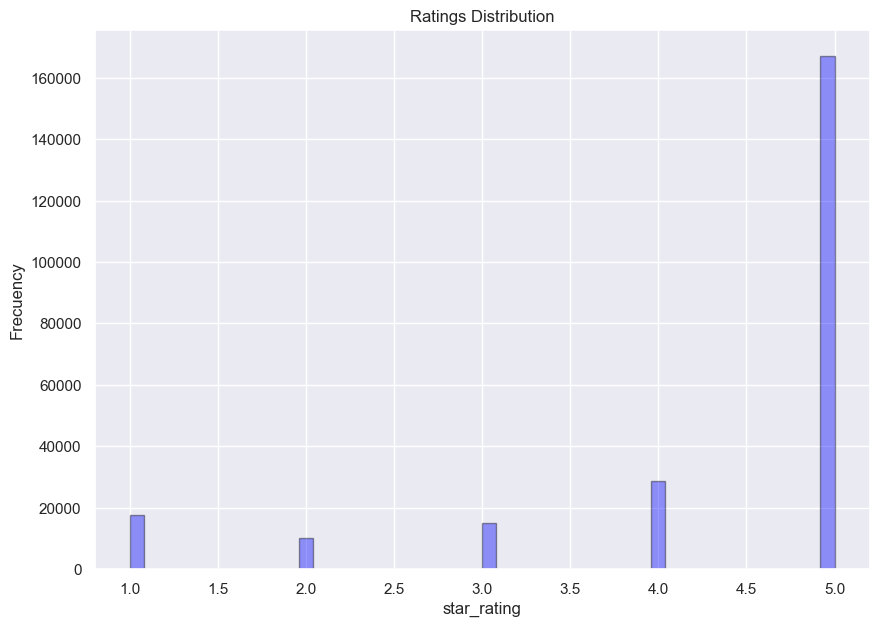

In [14]:
# seaborn histogram
sns.distplot(train_data['star_rating'], 
             hist=True, 
             kde=False, 
             color='blue',
             hist_kws={'edgecolor':'black'})

plt.title("Ratings Distribution")
plt.ylabel("Frecuency")
plt.show()

In [15]:
train_data = train_data.copy()
train_data['rating_bin'] = (train_data.star_rating>=4).astype('float32')
test_data['rating_bin'] = (test_data.star_rating>=4).astype('float32')
train_data.head()

customer_id  product_id                                      product_title  \
0         7269           1  Delgada coffee infused with Chaga 28 Sachets p...   
1       570641           2                        Communion Bread Pack of 500   
2       518854           2                        Communion Bread Pack of 500   
3       311501           2                        Communion Bread Pack of 500   
4       223609           2                        Communion Bread Pack of 500   

  product_category  star_rating review_date  rating_bin  
0          Grocery            5  2015-07-22         1.0  
1          Grocery            3  2015-08-04         0.0  
2          Grocery            5  2015-01-28         1.0  
3          Grocery            5  2012-05-20         1.0  
4          Grocery            2  2013-12-02         0.0

In [16]:
round(train_data.rating_bin.value_counts(normalize=True), 2)

1.0    0.82
0.0    0.18
Name: rating_bin, dtype: float64

In [17]:
train_data.groupby('customer_id').count().star_rating.sort_values()

customer_id
11          1
531929      1
531942      1
531948      1
531952      1
         ... 
793638     65
728381     68
733863     75
474731     75
720268    135
Name: star_rating, Length: 194421, dtype: int64

In [18]:
test_data.groupby('customer_id').count().star_rating.sort_values()

customer_id
11         1
542423     1
542432     1
542445     1
542446     1
          ..
795643    25
474731    26
375736    34
720268    60
728381    63
Name: star_rating, Length: 44205, dtype: int64

In [19]:
print('Customers of the test dataset are on the train dataset: {}'.format(test_data.customer_id.isin(train_data.customer_id).sum()==len(test_data.customer_id)))
print('Products of the test dataset are on the train dataset: {}'.format(test_data.product_id.isin(train_data.product_id).sum()==len(test_data.product_id)))

Customers of the test dataset are on the train dataset: True
Products of the test dataset are on the train dataset: True


In [20]:
print('The products that are in the test dataset and not in the train dataset are:')
test_data[test_data.product_id.isin(train_data.product_id)==False]

The products that are in the test dataset and not in the train dataset are:


Empty DataFrame
Columns: [customer_id, product_id, product_title, product_category, star_rating, review_date, rating_bin]
Index: []

In [21]:
# We remove the observations
test_data = test_data.drop(index=test_data[test_data.product_id.isin(train_data.product_id)==False].index)
test_data.reset_index(drop=True,inplace=True)

In [22]:
print('Customer of the test dataset are on the train dataset: {}'.format(test_data.customer_id.isin(train_data.customer_id).sum()==len(test_data.customer_id)))
print('Product of the test dataset are on the train dataset: {}'.format(test_data.product_id.isin(train_data.product_id).sum()==len(test_data.product_id)))

Customer of the test dataset are on the train dataset: True
Product of the test dataset are on the train dataset: True


In [23]:
#create sparse matrix
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train_data[['customer_id','product_id']])

X_train = enc.transform(train_data[['customer_id','product_id']]).astype('float32')
Y_train = train_data['rating_bin']

X_test = enc.transform(test_data[['customer_id','product_id']]).astype('float32')
Y_test = test_data['rating_bin']

In [24]:
print(X_train[:10])
print(type(X_train))

  (0, 1028)	1.0
  (0, 194421)	1.0
  (1, 134074)	1.0
  (1, 194422)	1.0
  (2, 121227)	1.0
  (2, 194422)	1.0
  (3, 70682)	1.0
  (3, 194422)	1.0
  (4, 49355)	1.0
  (4, 194422)	1.0
  (5, 137237)	1.0
  (5, 194422)	1.0
  (6, 17772)	1.0
  (6, 194422)	1.0
  (7, 92412)	1.0
  (7, 194422)	1.0
  (8, 177367)	1.0
  (8, 194422)	1.0
  (9, 70035)	1.0
  (9, 194422)	1.0
<class 'scipy.sparse._csr.csr_matrix'>


In [25]:
print(Y_test)

0        1.0
1        0.0
2        1.0
3        1.0
4        0.0
        ... 
47734    0.0
47735    1.0
47736    1.0
47737    1.0
47738    1.0
Name: rating_bin, Length: 47739, dtype: float32


In [26]:
columns = X_train.shape[1]

print("Columns:{} ".format(X_train.shape[1]))
print("Rows:{} ".format(X_train.shape[0]))

Columns:230845 
Rows:238699 


In [27]:
total = X_train.shape[0] * X_train.shape[1]
non_zero = X_train.nnz
sparsity = (total - non_zero) / total

print("Total elements:", total)
print("Non-zero elements:", non_zero)
print("Sparsity:", round(sparsity*100, 4), "%")

Total elements: 55102470655
Non-zero elements: 477398
Sparsity: 99.9991 %


# Upload training data

In [28]:
def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket, obj)

In [29]:
%%time
train_data_location = writeDatasetToProtobuf(X_train, Y_train, bucket, train_prefix, train_key)    
test_data_location = writeDatasetToProtobuf(X_test, Y_test, bucket, test_prefix, test_key)    
  
print(train_data_location)
print(test_data_location)
print('Output: {}'.format(output_prefix))

s3://sagemaker-ap-southeast-1-964448433964/builtin-notebooks/Recomendation-Machine/Explicit/train/train.protobuf
s3://sagemaker-ap-southeast-1-964448433964/builtin-notebooks/Recomendation-Machine/Explicit/test/test.protobuf
Output: s3://sagemaker-ap-southeast-1-964448433964/builtin-notebooks/Recomendation-Machine/Explicit/output
CPU times: total: 28.6 s
Wall time: 36.5 s


# Training the model

In [30]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker
from time import strftime, gmtime

In [31]:
create_date = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
sagemaker_experiment = Experiment.create(
    experiment_name="Experiment"+create_date,
    description="Using FM to predict",
    sagemaker_boto_client=boto3.client("sagemaker"),
)

In [32]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig
debug_rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.overfit()),
]


In [33]:
from sagemaker.image_uris import retrieve

#container = retrieve(region=boto3.Session().region_name, framework="factorization-machines")
container = sagemaker.image_uris.retrieve("factorization-machines", region=boto_session.region_name)
container

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


'475088953585.dkr.ecr.ap-southeast-1.amazonaws.com/factorization-machines:1'

In [34]:
fm = sagemaker.estimator.Estimator(
    container,
    role_arn,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=30,
    max_run=86400,
    output_path=output_prefix,
    sagemaker_session=sagemaker_session,
    rules=debug_rules
)

In [35]:
fm.set_hyperparameters(
    feature_dim=columns,
    num_factors=64,
    predictor_type='binary_classifier',
    epochs=100,
    mini_batch_size=500
)

In [36]:
data_channels = {
    "train": train_data_location,
    "test": test_data_location
}

In [37]:
trial = Trial.create(
    trial_name="algorithm-mode-trial-{}".format(strftime("%Y-%m-%d-%H-%M-%S", gmtime())),
    experiment_name=sagemaker_experiment.experiment_name,
    sagemaker_boto_client=boto3.client("sagemaker"),
)

In [38]:
fm.fit(
    {"train": train_data_location, "test": test_data_location},
    experiment_config={
        "ExperimentName": sagemaker_experiment.experiment_name,
        "TrialName": trial.trial_name,
        "TrialComponentDisplayName": "TrainingTrial",
    }, logs=True
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: factorization-machines-2023-08-30-11-02-34-424


2023-08-30 11:02:34 Starting - Starting the training job...
2023-08-30 11:02:59 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overtraining: InProgress
Overfit: InProgress
......
2023-08-30 11:04:04 Downloading - Downloading input data...
2023-08-30 11:04:29 Training - Downloading the training image...............
2023-08-30 11:06:58 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/30/2023 11:07:04 INFO 140026071775040] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'epochs': 1, 'mini_batch_size': '1000', 'use_bias': 'true', 'use_linear': 'true', 'bias_lr': '0.1', 'linear_lr': '0.001', 'factors_lr': '0.0001', 'bias_wd': '0.01', 'linear_wd': '0.001', 'factors_wd': '0.00001', 'bias_init_method': 'normal', 'bias_init_sigma': '0.01', 'linear_init_method': 'normal', 'linear_in

[2023-08-30 11:07:11.806] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 4, "duration": 3215, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:07:11 INFO 140026071775040] #quality_metric: host=algo-1, epoch=1, train binary_classification_accuracy <score>=0.8193933054393305
[08/30/2023 11:07:11 INFO 140026071775040] #quality_metric: host=algo-1, epoch=1, train binary_classification_cross_entropy <loss>=0.4727934141917209
[08/30/2023 11:07:11 INFO 140026071775040] #quality_metric: host=algo-1, epoch=1, train binary_f_1.000 <score>=0.9007324617383605
#metrics {"StartTime": 1693393628.5829756, "EndTime": 1693393631.8077106, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3223.0100631713867, "count": 1, "min": 3223.0100631713867, "max": 3223.0100631713867}}}
[08/30/2023 11:07:11 INFO 140026071775040] #progress_metric: host=algo-1, completed 2.0 % of epochs
#me

[2023-08-30 11:07:30.686] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 16, "duration": 3057, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:07:30 INFO 140026071775040] #quality_metric: host=algo-1, epoch=7, train binary_classification_accuracy <score>=0.8193933054393305
[08/30/2023 11:07:30 INFO 140026071775040] #quality_metric: host=algo-1, epoch=7, train binary_classification_cross_entropy <loss>=0.45790732194589273
[08/30/2023 11:07:30 INFO 140026071775040] #quality_metric: host=algo-1, epoch=7, train binary_f_1.000 <score>=0.9007324617383605
#metrics {"StartTime": 1693393647.5607567, "EndTime": 1693393650.6868646, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3124.7148513793945, "count": 1, "min": 3124.7148513793945, "max": 3124.7148513793945}}}
[08/30/2023 11:07:30 INFO 140026071775040] #progress_metric: host=algo-1, completed 8.0 % of epochs
#

[2023-08-30 11:07:49.599] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 28, "duration": 3064, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:07:49 INFO 140026071775040] #quality_metric: host=algo-1, epoch=13, train binary_classification_accuracy <score>=0.8193933054393305
[08/30/2023 11:07:49 INFO 140026071775040] #quality_metric: host=algo-1, epoch=13, train binary_classification_cross_entropy <loss>=0.4406441456942379
[08/30/2023 11:07:49 INFO 140026071775040] #quality_metric: host=algo-1, epoch=13, train binary_f_1.000 <score>=0.9007324617383605
#metrics {"StartTime": 1693393666.4819624, "EndTime": 1693393669.600223, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3116.804599761963, "count": 1, "min": 3116.804599761963, "max": 3116.804599761963}}}
[08/30/2023 11:07:49 INFO 140026071775040] #progress_metric: host=algo-1, completed 14.0 % of epochs
#m

[2023-08-30 11:08:02.448] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 36, "duration": 3409, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:08:02 INFO 140026071775040] #quality_metric: host=algo-1, epoch=17, train binary_classification_accuracy <score>=0.8193933054393305
[08/30/2023 11:08:02 INFO 140026071775040] #quality_metric: host=algo-1, epoch=17, train binary_classification_cross_entropy <loss>=0.4297328552501471
[08/30/2023 11:08:02 INFO 140026071775040] #quality_metric: host=algo-1, epoch=17, train binary_f_1.000 <score>=0.9007324617383605
#metrics {"StartTime": 1693393679.0310795, "EndTime": 1693393682.4495833, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3416.8667793273926, "count": 1, "min": 3416.8667793273926, "max": 3416.8667793273926}}}
[08/30/2023 11:08:02 INFO 140026071775040] #progress_metric: host=algo-1, completed 18.0 % of epoch

[2023-08-30 11:08:21.699] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 48, "duration": 3132, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:08:21 INFO 140026071775040] #quality_metric: host=algo-1, epoch=23, train binary_classification_accuracy <score>=0.8193933054393305
[08/30/2023 11:08:21 INFO 140026071775040] #quality_metric: host=algo-1, epoch=23, train binary_classification_cross_entropy <loss>=0.4145341507021852
[08/30/2023 11:08:21 INFO 140026071775040] #quality_metric: host=algo-1, epoch=23, train binary_f_1.000 <score>=0.9007324617383605
#metrics {"StartTime": 1693393698.5587158, "EndTime": 1693393701.700353, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3140.105724334717, "count": 1, "min": 3140.105724334717, "max": 3140.105724334717}}}
[08/30/2023 11:08:21 INFO 140026071775040] #progress_metric: host=algo-1, completed 24.0 % of epochs
#m

[2023-08-30 11:08:34.305] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 56, "duration": 3125, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:08:34 INFO 140026071775040] #quality_metric: host=algo-1, epoch=27, train binary_classification_accuracy <score>=0.8193933054393305
[08/30/2023 11:08:34 INFO 140026071775040] #quality_metric: host=algo-1, epoch=27, train binary_classification_cross_entropy <loss>=0.40514467809190313
[08/30/2023 11:08:34 INFO 140026071775040] #quality_metric: host=algo-1, epoch=27, train binary_f_1.000 <score>=0.9007324617383605
#metrics {"StartTime": 1693393711.168526, "EndTime": 1693393714.305971, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3135.9200477600098, "count": 1, "min": 3135.9200477600098, "max": 3135.9200477600098}}}
[08/30/2023 11:08:34 INFO 140026071775040] #progress_metric: host=algo-1, completed 28.0 % of epochs

[2023-08-30 11:08:53.101] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 68, "duration": 3116, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:08:53 INFO 140026071775040] #quality_metric: host=algo-1, epoch=33, train binary_classification_accuracy <score>=0.819397489539749
[08/30/2023 11:08:53 INFO 140026071775040] #quality_metric: host=algo-1, epoch=33, train binary_classification_cross_entropy <loss>=0.3920501337410516
[08/30/2023 11:08:53 INFO 140026071775040] #quality_metric: host=algo-1, epoch=33, train binary_f_1.000 <score>=0.9007345331781783
#metrics {"StartTime": 1693393729.9777217, "EndTime": 1693393733.1023881, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3123.1396198272705, "count": 1, "min": 3123.1396198272705, "max": 3123.1396198272705}}}
[08/30/2023 11:08:53 INFO 140026071775040] #progress_metric: host=algo-1, completed 34.0 % of epochs

[2023-08-30 11:09:12.680] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 80, "duration": 3141, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:09:12 INFO 140026071775040] #quality_metric: host=algo-1, epoch=39, train binary_classification_accuracy <score>=0.819397489539749
[08/30/2023 11:09:12 INFO 140026071775040] #quality_metric: host=algo-1, epoch=39, train binary_classification_cross_entropy <loss>=0.379988334719606
[08/30/2023 11:09:12 INFO 140026071775040] #quality_metric: host=algo-1, epoch=39, train binary_f_1.000 <score>=0.9007345331781783
#metrics {"StartTime": 1693393749.5316727, "EndTime": 1693393752.6809046, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3147.6590633392334, "count": 1, "min": 3147.6590633392334, "max": 3147.6590633392334}}}
[08/30/2023 11:09:12 INFO 140026071775040] #progress_metric: host=algo-1, completed 40.0 % of epochs


[2023-08-30 11:09:25.279] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 88, "duration": 3161, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:09:25 INFO 140026071775040] #quality_metric: host=algo-1, epoch=43, train binary_classification_accuracy <score>=0.8194267782426778
[08/30/2023 11:09:25 INFO 140026071775040] #quality_metric: host=algo-1, epoch=43, train binary_classification_cross_entropy <loss>=0.37244350701495693
[08/30/2023 11:09:25 INFO 140026071775040] #quality_metric: host=algo-1, epoch=43, train binary_f_1.000 <score>=0.9007490335236772
#metrics {"StartTime": 1693393762.1068163, "EndTime": 1693393765.2805686, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3172.1646785736084, "count": 1, "min": 3172.1646785736084, "max": 3172.1646785736084}}}
[08/30/2023 11:09:25 INFO 140026071775040] #progress_metric: host=algo-1, completed 44.0 % of epoc

[2023-08-30 11:09:44.209] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 100, "duration": 3121, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:09:44 INFO 140026071775040] #quality_metric: host=algo-1, epoch=49, train binary_classification_accuracy <score>=0.8194686192468619
[08/30/2023 11:09:44 INFO 140026071775040] #quality_metric: host=algo-1, epoch=49, train binary_classification_cross_entropy <loss>=0.3617724178425937
[08/30/2023 11:09:44 INFO 140026071775040] #quality_metric: host=algo-1, epoch=49, train binary_f_1.000 <score>=0.9007697491128451
#metrics {"StartTime": 1693393781.080576, "EndTime": 1693393784.2102673, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3128.09419631958, "count": 1, "min": 3128.09419631958, "max": 3128.09419631958}}}
[08/30/2023 11:09:44 INFO 140026071775040] #progress_metric: host=algo-1, completed 50.0 % of epochs
#met

[2023-08-30 11:09:56.793] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 108, "duration": 3137, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:09:56 INFO 140026071775040] #quality_metric: host=algo-1, epoch=53, train binary_classification_accuracy <score>=0.8195523012552302
[08/30/2023 11:09:56 INFO 140026071775040] #quality_metric: host=algo-1, epoch=53, train binary_classification_cross_entropy <loss>=0.3550407562575081
[08/30/2023 11:09:56 INFO 140026071775040] #quality_metric: host=algo-1, epoch=53, train binary_f_1.000 <score>=0.9008111831498378
#metrics {"StartTime": 1693393793.647896, "EndTime": 1693393796.794708, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3145.205497741699, "count": 1, "min": 3145.205497741699, "max": 3145.205497741699}}}
[08/30/2023 11:09:56 INFO 140026071775040] #progress_metric: host=algo-1, completed 54.0 % of epochs
#m

[2023-08-30 11:10:16.481] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 120, "duration": 3148, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:10:16 INFO 140026071775040] #quality_metric: host=algo-1, epoch=59, train binary_classification_accuracy <score>=0.8198075313807531
[08/30/2023 11:10:16 INFO 140026071775040] #quality_metric: host=algo-1, epoch=59, train binary_classification_cross_entropy <loss>=0.34544746239315016
[08/30/2023 11:10:16 INFO 140026071775040] #quality_metric: host=algo-1, epoch=59, train binary_f_1.000 <score>=0.9009375805086305
#metrics {"StartTime": 1693393813.3259013, "EndTime": 1693393816.4822085, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3154.7670364379883, "count": 1, "min": 3154.7670364379883, "max": 3154.7670364379883}}}
[08/30/2023 11:10:16 INFO 140026071775040] #progress_metric: host=algo-1, completed 60.0 % of epo

[2023-08-30 11:10:35.439] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 132, "duration": 3127, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:10:35 INFO 140026071775040] #quality_metric: host=algo-1, epoch=65, train binary_classification_accuracy <score>=0.8202175732217574
[08/30/2023 11:10:35 INFO 140026071775040] #quality_metric: host=algo-1, epoch=65, train binary_classification_cross_entropy <loss>=0.3363906063255406
[08/30/2023 11:10:35 INFO 140026071775040] #quality_metric: host=algo-1, epoch=65, train binary_f_1.000 <score>=0.9011407194032736
#metrics {"StartTime": 1693393832.3032444, "EndTime": 1693393835.4397037, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3134.890079498291, "count": 1, "min": 3134.890079498291, "max": 3134.890079498291}}}
[08/30/2023 11:10:35 INFO 140026071775040] #progress_metric: host=algo-1, completed 66.0 % of epochs


[2023-08-30 11:10:47.978] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 140, "duration": 3119, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:10:47 INFO 140026071775040] #quality_metric: host=algo-1, epoch=69, train binary_classification_accuracy <score>=0.8207824267782426
[08/30/2023 11:10:47 INFO 140026071775040] #quality_metric: host=algo-1, epoch=69, train binary_classification_cross_entropy <loss>=0.33061856992075134
[08/30/2023 11:10:47 INFO 140026071775040] #quality_metric: host=algo-1, epoch=69, train binary_f_1.000 <score>=0.9014207036545202
#metrics {"StartTime": 1693393844.8516638, "EndTime": 1693393847.9795132, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3126.283645629883, "count": 1, "min": 3126.283645629883, "max": 3126.283645629883}}}
[08/30/2023 11:10:47 INFO 140026071775040] #progress_metric: host=algo-1, completed 70.0 % of epochs

[2023-08-30 11:11:00.572] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 148, "duration": 3167, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:11:00 INFO 140026071775040] #quality_metric: host=algo-1, epoch=73, train binary_classification_accuracy <score>=0.8218242677824268
[08/30/2023 11:11:00 INFO 140026071775040] #quality_metric: host=algo-1, epoch=73, train binary_classification_cross_entropy <loss>=0.32504016563383603
[08/30/2023 11:11:00 INFO 140026071775040] #quality_metric: host=algo-1, epoch=73, train binary_f_1.000 <score>=0.9019375757045416
#metrics {"StartTime": 1693393857.3971896, "EndTime": 1693393860.5735042, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3174.7591495513916, "count": 1, "min": 3174.7591495513916, "max": 3174.7591495513916}}}
[08/30/2023 11:11:00 INFO 140026071775040] #progress_metric: host=algo-1, completed 74.0 % of epo

[2023-08-30 11:11:20.124] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 160, "duration": 3116, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:11:20 INFO 140026071775040] #quality_metric: host=algo-1, epoch=79, train binary_classification_accuracy <score>=0.8231715481171548
[08/30/2023 11:11:20 INFO 140026071775040] #quality_metric: host=algo-1, epoch=79, train binary_classification_cross_entropy <loss>=0.3170052192400689
[08/30/2023 11:11:20 INFO 140026071775040] #quality_metric: host=algo-1, epoch=79, train binary_f_1.000 <score>=0.9026068600610234
#metrics {"StartTime": 1693393876.9995906, "EndTime": 1693393880.1252203, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3124.0296363830566, "count": 1, "min": 3124.0296363830566, "max": 3124.0296363830566}}}
[08/30/2023 11:11:20 INFO 140026071775040] #progress_metric: host=algo-1, completed 80.0 % of epoc

[2023-08-30 11:11:39.049] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 172, "duration": 3181, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:11:39 INFO 140026071775040] #quality_metric: host=algo-1, epoch=85, train binary_classification_accuracy <score>=0.8255020920502092
[08/30/2023 11:11:39 INFO 140026071775040] #quality_metric: host=algo-1, epoch=85, train binary_classification_cross_entropy <loss>=0.3093337420539377
[08/30/2023 11:11:39 INFO 140026071775040] #quality_metric: host=algo-1, epoch=85, train binary_f_1.000 <score>=0.903766501374105
#metrics {"StartTime": 1693393895.8573039, "EndTime": 1693393899.0503602, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3191.538095474243, "count": 1, "min": 3191.538095474243, "max": 3191.538095474243}}}
[08/30/2023 11:11:39 INFO 140026071775040] #progress_metric: host=algo-1, completed 86.0 % of epochs
#

[2023-08-30 11:11:51.702] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 180, "duration": 3145, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:11:51 INFO 140026071775040] #quality_metric: host=algo-1, epoch=89, train binary_classification_accuracy <score>=0.8274518828451883
[08/30/2023 11:11:51 INFO 140026071775040] #quality_metric: host=algo-1, epoch=89, train binary_classification_cross_entropy <loss>=0.3044042696454036
[08/30/2023 11:11:51 INFO 140026071775040] #quality_metric: host=algo-1, epoch=89, train binary_f_1.000 <score>=0.9047393551039831
#metrics {"StartTime": 1693393908.5455408, "EndTime": 1693393911.7038286, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3156.6367149353027, "count": 1, "min": 3156.6367149353027, "max": 3156.6367149353027}}}
[08/30/2023 11:11:51 INFO 140026071775040] #progress_metric: host=algo-1, completed 90.0 % of epoc

[2023-08-30 11:12:11.202] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 192, "duration": 3170, "num_examples": 478, "num_bytes": 16157236}
[08/30/2023 11:12:11 INFO 140026071775040] #quality_metric: host=algo-1, epoch=95, train binary_classification_accuracy <score>=0.831326359832636
[08/30/2023 11:12:11 INFO 140026071775040] #quality_metric: host=algo-1, epoch=95, train binary_classification_cross_entropy <loss>=0.2972654538972607
[08/30/2023 11:12:11 INFO 140026071775040] #quality_metric: host=algo-1, epoch=95, train binary_f_1.000 <score>=0.9066787659642438
#metrics {"StartTime": 1693393928.0255997, "EndTime": 1693393931.203824, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 3176.701068878174, "count": 1, "min": 3176.701068878174, "max": 3176.701068878174}}}
[08/30/2023 11:12:11 INFO 140026071775040] #progress_metric: host=algo-1, completed 96.0 % of epochs
#m

[2023-08-30 11:12:28.925] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/test", "epoch": 1, "duration": 4527, "num_examples": 96, "num_bytes": 3229628}
#metrics {"StartTime": 1693393944.3974333, "EndTime": 1693393948.9254818, "Dimensions": {"Algorithm": "factorization-machines", "Host": "algo-1", "Operation": "training", "Meta": "test_data_iter"}, "Metrics": {"Total Records Seen": {"sum": 47739.0, "count": 1, "min": 47739, "max": 47739}, "Total Batches Seen": {"sum": 96.0, "count": 1, "min": 96, "max": 96}, "Max Records Seen Between Resets": {"sum": 47739.0, "count": 1, "min": 47739, "max": 47739}, "Max Batches Seen Between Resets": {"sum": 96.0, "count": 1, "min": 96, "max": 96}, "Reset Count": {"sum": 1.0, "count": 1, "min": 1, "max": 1}, "Number of Records Since Last Reset": {"sum": 47739.0, "count": 1, "min": 47739, "max": 47739}, "Number of Batches Since Last Reset": {"sum": 96.0, "count": 1, "min": 96, "max": 96}}}
[08/30/2023 11:12:28 INFO 140026071775040] #

In [39]:
from sagemaker import analytics
trial_component_analytics = analytics.ExperimentAnalytics(experiment_name=sagemaker_experiment.experiment_name)

analytic_table = trial_component_analytics.dataframe()
analytic_table

TrialComponentName    DisplayName  \
0  factorization-machines-2023-08-30-11-02-34-424...  TrainingTrial   

                                           SourceArn  \
0  arn:aws:sagemaker:ap-southeast-1:964448433964:...   

                                  SageMaker.ImageUri  SageMaker.InstanceCount  \
0  475088953585.dkr.ecr.ap-southeast-1.amazonaws....                      1.0   

  SageMaker.InstanceType  SageMaker.VolumeSizeInGB  epochs  feature_dim  \
0           ml.m4.xlarge                      30.0   100.0     230845.0   

   mini_batch_size  ...  test - MediaType  \
0            500.0  ...              None   

                                        test - Value  train - MediaType  \
0  s3://sagemaker-ap-southeast-1-964448433964/bui...               None   

                                       train - Value  \
0  s3://sagemaker-ap-southeast-1-964448433964/bui...   

   SageMaker.DebugHookOutput - MediaType  \
0                                   None   

                   SageMaker.DebugHookOutput - Value  \
0  s3://sagemaker-ap-southeast-1-964448433964/bui...   

   SageMaker.ModelArtifact - MediaType  \
0                                 None   

                     SageMaker.ModelArtifact - Value  \
0  s3://sagemaker-ap-southeast-1-964448433964/bui...   

                                       Trials                      Experiments  
0  [algorithm-mode-trial-2023-08-30-11-02-34]  [Experiment2023-08-30-11-02-33]  

[1 rows x 106 columns]

In [40]:
# %%time 

# fm.fit(inputs=data_channels, logs=True)

In [41]:
training_job_name = fm._current_job_name
metric_name = 'train:binary_classification_cross_entropy:epoch'
training_job_name

'factorization-machines-2023-08-30-11-02-34-424'

In [42]:
# run this cell to check current status of training job
fm_training_job_result = sagemaker_boto_client.describe_training_job(TrainingJobName=training_job_name)

status = fm_training_job_result['TrainingJobStatus']
if status != 'Completed':
    print('Reminder: the training job has not been completed.')
else:
    print('The training job is completed')

The training job is completed


In [43]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics, TrainingJobAnalytics
# plug-in the training job name and metrics to be captured
metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
metrics_dataframe

timestamp                                      metric_name     value
0        0.0  train:binary_classification_cross_entropy:epoch  0.454677
1       60.0  train:binary_classification_cross_entropy:epoch  0.409067
2      120.0  train:binary_classification_cross_entropy:epoch  0.370934
3      180.0  train:binary_classification_cross_entropy:epoch  0.339560
4      240.0  train:binary_classification_cross_entropy:epoch  0.313270
5      300.0  train:binary_classification_cross_entropy:epoch  0.296704

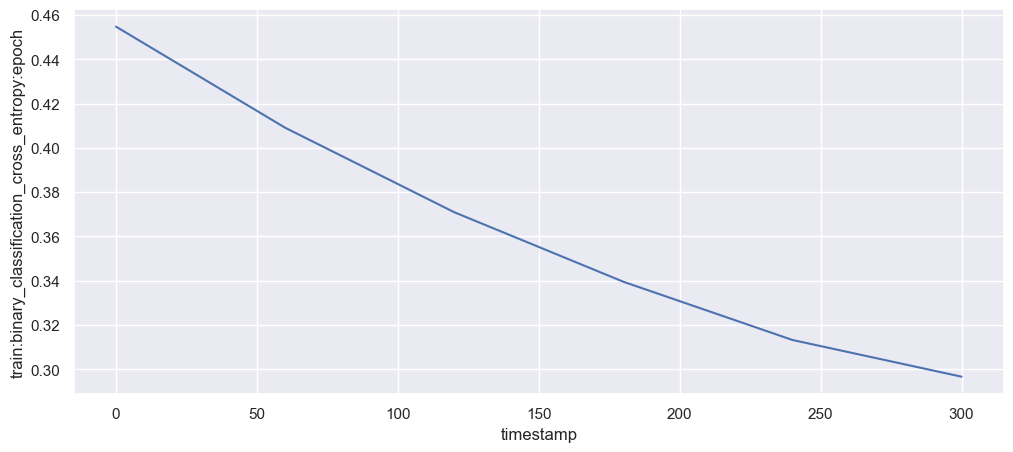

In [44]:
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b-', legend=False)
plt.set_ylabel(metric_name);

In [45]:
from IPython.display import display, display_markdown

job_desc = fm.latest_training_job.describe()

job_name = job_desc["TrainingJobName"]
job_arn = job_desc["TrainingJobArn"]
creation_time = job_desc["CreationTime"]
train_start_time = job_desc["TrainingStartTime"]
train_end_time = job_desc["TrainingEndTime"]
job_output = job_desc["ModelArtifacts"]["S3ModelArtifacts"]
train_time = job_desc["TrainingTimeInSeconds"]

desc_md = f"""# **Train Job**
| | |
|---|---|
| **Name** | {job_name} |
| **ARN**  | {job_arn} |
| **Creation Time** | {creation_time} |
| **Output** | {job_output} |
| **Training Start Time** | {train_start_time} |
| **Training End Time** | {train_end_time} |
| **Training Time** | {train_time} seconds |
| **Training Set Input** | {s3_train} |

## Hyperparameters
| | |
|---|---|
"""
for name, val in job_desc["HyperParameters"].items():
    desc_md += f"| **{name}** | {val} |\n"

desc_md += """
## Metrics
| | |
|---|---|
"""
for metric in job_desc["FinalMetricDataList"]:
    name, val = metric["MetricName"], metric["Value"]
    desc_md += f"| **{name}** | {val} |\n"

display_markdown(desc_md, raw=True)

# **Train Job**
| | |
|---|---|
| **Name** | factorization-machines-2023-08-30-11-02-34-424 |
| **ARN**  | arn:aws:sagemaker:ap-southeast-1:964448433964:training-job/factorization-machines-2023-08-30-11-02-34-424 |
| **Creation Time** | 2023-08-30 18:02:34.608000+07:00 |
| **Output** | s3://sagemaker-ap-southeast-1-964448433964/builtin-notebooks/Recomendation-Machine/Explicit/output/factorization-machines-2023-08-30-11-02-34-424/output/model.tar.gz |
| **Training Start Time** | 2023-08-30 18:04:03.772000+07:00 |
| **Training End Time** | 2023-08-30 18:13:02.950000+07:00 |
| **Training Time** | 539 seconds |
| **Training Set Input** | s3://sagemaker-ap-southeast-1-964448433964/builtin-notebooks/Recomendation-Machine/Explicit/train/ |

## Hyperparameters
| | |
|---|---|
| **epochs** | 100 |
| **feature_dim** | 230845 |
| **mini_batch_size** | 500 |
| **num_factors** | 64 |
| **predictor_type** | binary_classifier |

## Metrics
| | |
|---|---|
| **train:progress** | 100.0 |
| **test:binary_f_beta** | 0.9364421367645264 |
| **train:binary_classification_accuracy:batch** | 0.8640000224113464 |
| **train:binary_f_beta:batch** | 0.9256017208099365 |
| **train:binary_classification_cross_entropy:epoch** | 0.29266536235809326 |
| **train:binary_f_beta** | 0.9084579348564148 |
| **train:binary_classification_cross_entropy** | 0.29266536235809326 |
| **train:binary_f_beta:epoch** | 0.9084579348564148 |
| **train:binary_classification_accuracy:epoch** | 0.8348661065101624 |
| **train:binary_classification_accuracy** | 0.8348661065101624 |
| **test:binary_classification_cross_entropy** | 0.2863393723964691 |
| **train:throughput** | 75438.890625 |
| **test:binary_classification_accuracy** | 0.8879113793373108 |
| **train:binary_classification_cross_entropy:batch** | 0.27557373046875 |


# Perform Batch Inference

In [46]:
def writeDatasetToProtobuf2(X, bucket, prefix, key, d_type, Y=None):
    buf = io.BytesIO()
    if d_type=="sparse":
        smac.write_spmatrix_to_sparse_tensor(buf, X, labels=Y)
    else:
        smac.write_numpy_to_dense_tensor(buf, X, labels=Y)
        
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)

In [47]:
#upload inference data to S3
s3_batch_output = "s3://{}/{}/batch_output/".format(bucket, prefix)
prefix_batch = "{}/batch_inference".format(prefix)

s3_batch_input = writeDatasetToProtobuf2(X_test, bucket, prefix_batch, test_key, "sparse")
print ("Batch inference data path: ",s3_batch_input)

Batch inference data path:  s3://sagemaker-ap-southeast-1-964448433964/builtin-notebooks/Recomendation-Machine/Explicit/batch_inference/test.protobuf


In [48]:
fm_transformer = fm.transformer(
    instance_count=1,
    output_path=s3_batch_output,
    instance_type="ml.m4.xlarge",
    max_payload=1,
)

INFO:sagemaker:Creating model with name: factorization-machines-2023-08-30-11-13-42-915


In [49]:
import uuid

In [50]:
%%time 

transform_job_name = f"{job_name}-{str(uuid.uuid4())[:8]}"
display(f"Launching Batch Transform Job {transform_job_name}")

s3_batch_inference = "s3://{}/{}/batch_inference/".format(bucket, prefix)

fm_transformer.transform(
    data=s3_batch_inference,
    split_type='RecordIO',
    content_type="application/x-recordio-protobuf",
    job_name=transform_job_name,
    wait=True,
    logs=False
)

'Launching Batch Transform Job factorization-machines-2023-08-30-11-02-34-424-d7f39078'

INFO:sagemaker:Creating transform job with name: factorization-machines-2023-08-30-11-02-34-424-d7f39078


.........................................................................................!
CPU times: total: 188 ms
Wall time: 7min 35s


In [51]:
#Download predictions 
results_file_name = "inference_batch_output"
results_prefix_name = '{}/batch_output/test.protobuf.out'.format(prefix)
s3_client = boto3.client('s3')
s3_client.download_file(bucket, results_prefix_name, results_file_name)
with open(results_file_name) as f:
    results = f.readlines() 

In [52]:
pd.concat([pd.Series(results,name='predicted_label').apply(json.loads).apply(lambda x: x['predicted_label']),pd.Series(results,name='score').apply(json.loads).apply(lambda x: x['score']),test_data.star_rating,Y_test],axis=1)

predicted_label     score  star_rating  rating_bin
0                  1.0  0.853028            5         1.0
1                  1.0  0.533257            3         0.0
2                  1.0  0.787258            5         1.0
3                  1.0  0.786216            5         1.0
4                  1.0  0.529200            2         0.0
...                ...       ...          ...         ...
47734              1.0  0.669164            1         0.0
47735              1.0  0.859639            5         1.0
47736              1.0  0.860172            5         1.0
47737              1.0  0.859965            4         1.0
47738              1.0  0.857898            5         1.0

[47739 rows x 4 columns]

In [53]:
from sklearn.metrics import accuracy_score

print('The accuracy in dataset test is: {}'.format(accuracy_score(Y_test, pd.Series(results,name='predicted_label').apply(json.loads).apply(lambda x: x['predicted_label'])).round(2)))

The accuracy in dataset test is: 0.89


In [54]:
# from sklearn.metrics import accuracy_score

# pd = pd.concat([pd.Series(results,name='predicted_label_train').apply(json.loads).apply(lambda x: x['predicted_label_train']),pd.Series(results,name='score').apply(json.loads).apply(lambda x: x['score']),train_data.star_rating,Y_train],axis=1)
# #print('The accuracy in dataset train is: {}'.format(accuracy_score(Y_train, pd.Series(results,name='predicted_label_train').apply(json.loads).apply(lambda x: x['predicted_label_train'])).round(2)))

In [55]:
from sklearn.metrics import log_loss

# Đoạn mã để lấy kết quả dự đoán và điểm số từ mô hình
predicted_labels = pd.Series(results, name='predicted_label').apply(json.loads).apply(lambda x: x['predicted_label'])
scores = pd.Series(results, name='score').apply(json.loads).apply(lambda x: x['score'])

loss = log_loss(Y_test, scores)

print('The log loss on the test dataset is: {}'.format(loss))


The log loss on the test dataset is: 0.28633937911730345


# Real-time Prediction

In [56]:
%%time
fm_predictor = fm.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    deserializer= JSONDeserializer()
)

INFO:sagemaker:Creating model with name: factorization-machines-2023-08-30-11-21-20-714
INFO:sagemaker:Creating endpoint-config with name factorization-machines-2023-08-30-11-21-20-714
INFO:sagemaker:Creating endpoint with name factorization-machines-2023-08-30-11-21-20-714


-------!CPU times: total: 46.9 ms
Wall time: 4min 2s


In [57]:
endpoint_name = fm_predictor.endpoint_name
display(f"Endpoints name: {endpoint_name}")

'Endpoints name: factorization-machines-2023-08-30-11-21-20-714'

In [58]:
fm_predictor = sagemaker.predictor.Predictor(endpoint_name, 
                                             sagemaker_session=sagemaker.Session(), 
                                             #serializer=FMSerializer(),
                                             deserializer=JSONDeserializer()
                                            )

In [65]:
def getDataByYear(data, year = None):
    data = data.copy()
    if not pd.api.types.is_datetime64_any_dtype(data["review_date"]):
        data["review_date"] = pd.to_datetime(data["review_date"])
    if year != None:  
        filtered_data = data[data["review_date"].dt.year == year]
    else:
        filtered_data = train_data
    
    return filtered_data


# data = getDataByYear(train_data)
# data.head(10)

In [66]:
def getCustomer(df, num, year=None):
    df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    df["review_date"] = pd.to_datetime(df["review_date"])
    if year is not None:
        data = df[df["review_date"].dt.year == year]
        data = data.groupby("customer_id").count()["product_id"].sort_values(ascending=False).head(num)
    else:
        data = df.groupby("customer_id").count()["product_id"].sort_values(ascending=False).head(num)
    return data

# result = getCustomer(train_data,10,2014)
# print(result)


In [63]:
import numpy as np
import pandas as pd
import json
import pprint

# Define the recommend function
def getRecommendation(customer_id, df,top_k,year = None):
    
    product_info = df[['product_id', 'product_title']]
    # Remove duplicate rows based on 'product_id'
    product_info = product_info.drop_duplicates(subset=['product_id'])
    
    data = getDataByYear(df,year)
    
    # Initialize a dictionary to hold instances for inference
    js = {'instances': []}
    # Calculate the shape of feature space for encoding
    shape = len(enc.categories_[0]) + len(enc.categories_[1])

    # Number of inferences to make at a time
    cant_inferencias = 100
    recommend_df = pd.DataFrame()
    
    # Find product rated by the user and those not rated
    product = data.product_id[data.customer_id == customer_id]
    product_not = set(data.product_id.unique()) - set(product)
    # Get the index of the user from encoding categories
    customer_id_index = np.where(enc.categories_[0] == customer_id)[0][0]
    
    # Populate the js dictionary with instances for inference
    for m in product_not:
        product_index = np.where(enc.categories_[1] == m)[0][0]
        js['instances'].append({
            "data": {
                "features": {
                    "keys": [int(customer_id_index), int(product_index)],
                    "shape": [shape],
                    "values": [1, 1]
                }
            }
        })
    # Make inferences by parts and join the results
    results = []
    for i in range(0, len(js['instances']), cant_inferencias):
        part_js = {'instances': js['instances'][i:i+cant_inferencias]}
        part_json = json.dumps(part_js)
        result = fm_predictor.predict(part_json, initial_args={"ContentType": "application/json"})
        results.extend(result['predictions'])
    
    # Create a DataFrame from the inference results
    recommend_df = pd.DataFrame.from_dict(results)
    recommend_df['customer_id'] = customer_id
    recommend_df['product_id'] = list(product_not)
    
    # Keep only the top k recommendations based on score
    top_recommendations = recommend_df[recommend_df.predicted_label == 1].nlargest(top_k, 'score')
    top_recommendations
    
    # Merge the recommendations DataFrame with the product names DataFrame
    top_recommendations_with_names = top_recommendations.merge(product_info, left_on="product_id", right_on="product_id", how="left")

    # Drop the 'product_id' column as it's not needed anymore
    top_recommendations_with_names = top_recommendations_with_names[["product_id", "product_title","score"]].reset_index(drop=True)
    
    return top_recommendations_with_names
    
# Call the recommend function with the appropriate customer_id and data
recommendations = getRecommendation(507357, train_data,10)
print(recommendations)

   product_id                                      product_title     score
0       19259  Flower Cake Decorations(9413) - WILDFLOWERS ED...  0.869010
1       28135    San-J Szechuan Sauce, 64-Ounce Jugs (Pack of 2)  0.854253
2       19254  The Organic Coffee Co. Organic Ground French R...  0.853109
3       33890  Stash Pomegranate Raspberry Green Tea with Mat...  0.853058
4       20615  Klein's Naturals Dried Blueberries, 5-Ounce Tu...  0.851811
5       14099  Betty Lou's Coconut Macadamia Nut Butter Balls...  0.851786
6       23462  Imagine Organic Soup,Corn & Lemongrass Soup, 1...  0.850807
7       34754         White Chocolate Covered Christmas Pretzels  0.849795
8       25701                                      Vanilla Paste  0.849070
9       33810                  Frontier Se Chung Oolong (1x1LB )  0.848508


In [64]:
import pandas as pd
import numpy as np
import json
import ipywidgets as widgets
from IPython.display import display, clear_output,Markdown,HTML

# Define your train_data
train_data = train_data  

# Create input widgets
customer_id_input = widgets.Text(description='Customer ID:',
                                style={'description_width': 'initial', 'border': '5px solid blue', 'color': 'red'},
                                layout=widgets.Layout(width='398px', margin='5px 0 1px 54px')
)
year_input = widgets.Dropdown(description='Year:',
                              options=['Get Full Data'] + list(map(str, range(2000, 2020))),
                              style={'description_width': 'initial', 'border': '2px solid blue', 'color': 'red'},
                              layout=widgets.Layout(margin='5px 0 1px 98px')
)
num_customers = widgets.Text(
    description='Number of Customer:',
    style={'description_width': 'initial', 'border': '5px solid blue', 'color': 'red'},
    layout=widgets.Layout(width='398px', margin='5px 5px 20px 4px')
)

top_k_input = widgets.IntSlider(min=1, max=20, value=10)

# Create output widgets
outPutIds = widgets.Output()
output = widgets.Output()

# Create the widgets for "Top Recommendations"
top_k_label = widgets.Label("Top Recommendations:", style={'margin-top': '20px'})
top_k_widget = widgets.HBox([top_k_label, top_k_input])
top_k_widget.layout.visibility = 'hidden'

def get_customer_ids(btn):
    with outPutIds:
        outPutIds.clear_output()
        num = int(num_customers.value)
        year = None if year_input.value == 'Get Full Data' else int(year_input.value)
        customer_ids = getCustomer(train_data, num, year)
        display(HTML("<h3>Top {} Customers</h3>".format(num)))
        display(customer_ids)
        display(customer_id_input)
        top_k_widget.layout.visibility = 'visible'
        submit_button.disabled = False

def show_recommendations(btn):
    with output:
        output.clear_output()
        customer_id = int(customer_id_input.value)
        top_k = int(top_k_input.value)
        year = None if year_input.value == 'Get Full Data' else int(year_input.value)
        recommendations = getRecommendation(customer_id, train_data, top_k, year)
        #display(recommendations)
        display(HTML("<h3>Top {} Recommendations</h3>".format(top_k)))
        display(recommendations)
        

def clear_output_widgets(btn):
    with outPutIds:
        outPutIds.clear_output()
        
    with output:
        output.clear_output()
        
    num_customers.value = ''
    year_input.value = 'Get Full Data'    
    customer_id_input.value = ''
    top_k_widget.layout.visibility = 'hidden'

def exit_program(btn):
    clear_output(wait=True)
    print("Program has been exited.")

# Create buttons
submit_button_ids = widgets.Button(description='Get Id List')
submit_button_ids.on_click(get_customer_ids)

submit_button = widgets.Button(description='Get Recommendations')
submit_button.on_click(show_recommendations)
submit_button.disabled = True

clear_button = widgets.Button(description='Clear Output')
clear_button.on_click(clear_output_widgets)

exit_button = widgets.Button(description='Exit Program')
exit_button.on_click(exit_program)

# Arrange widgets
input_widgets = widgets.VBox([year_input, num_customers, submit_button_ids])
buttons = widgets.HBox([submit_button, clear_button, exit_button])
widgets.VBox([input_widgets, outPutIds, output, top_k_widget, buttons])


Program has been exited.
